In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport simulation
%aimport mathf
%aimport util
%aimport inference
%aimport graph
%aimport hyper
%aimport seq

In [2]:
import os.path
from datetime import datetime
import numpy as np
from scipy import stats
from scipy import linalg
from sklearn.decomposition.factor_analysis import FactorAnalysis
from scipy.io import loadmat, savemat
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat, lagmat2ds
import pandas as pd
from scipy.linalg import orth
from numpy.linalg import norm
from numpy import dstack, rollaxis

import simulation, util, inference, graph, hyper, seq
from mathf import ichol_gauss, subspace
from util import rad2deg, rotate, add_constant

# plot setting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from matplotlib import colors
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.patches import FancyBboxPatch
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import set_matplotlib_formats
import seaborn as sns

/Users/yuan/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
sns.set_style("white")
samplepath = os.path.expanduser("~/data/sample")
outputpath = os.path.expanduser("~/data/output")
figurepath = os.path.expanduser("~/variational-doc/figure")


In [37]:
Lorenz_vLGP = []
b = np.empty((11, 50, 5))
for i in range(5):
    Lorenz_vLGP.append(loadmat('{}/lorenz_{}_vLGP'.format(outputpath, i + 1), squeeze_me=True))
    b[:,:,i] = Lorenz_vLGP[i]['b']

In [8]:
beta = Lorenz_vLGP[0]['beta']

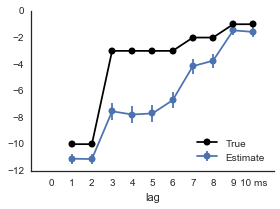

In [96]:
x = np.arange(11)[1:]
y = b.mean(axis=(1,2))[1:]
yerr = 1.96 * b.std(axis=(1,2))[1:] / np.sqrt(250)
plt.figure(figsize=(4,3))
plt.errorbar(x, y, yerr=yerr, linestyle='-', fmt='o', label='Estimate');
plt.plot(x, beta[1:, 0], marker='o', color='k', label='True');
plt.xlim([-1, 11]);
# plt.ylim([-11, 0]);
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10 ms']);
plt.xlabel('lag');
# Only show ticks on the left and bottom spines
plt.legend(loc='lower right');
plt.tight_layout()
plt.savefig(os.path.join(figurepath, 'beta.pdf'))

In [97]:
LorenzCV_vLGP = [loadmat('{}/lorenz_{}_vLGP_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(5)]
LorenzCV_PLDS = [loadmat('{}/lorenz_{}_PLDS_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(5)]
LorenzCV_GPFA = [loadmat('{}/lorenz_{}_GPFA_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(5)]

/Users/yuan/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


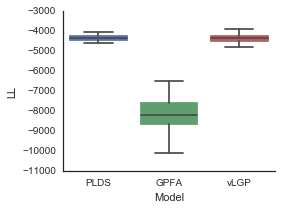

In [101]:
LL = np.zeros((5, 10, 3))
sns.set_style("white")
for i in range(5):
    LL[i, :, 2] = np.nansum(stats.poisson.logpmf(LorenzCV_vLGP[i]['y'], LorenzCV_vLGP[i]['yhat']), axis=(1, 2))
    LL[i, :, 1] = np.nansum(stats.poisson.logpmf(LorenzCV_vLGP[i]['y'], LorenzCV_GPFA[i]['yhat']**2), axis=(1, 2))
    LL[i, :, 0] = np.nansum(stats.poisson.logpmf(LorenzCV_vLGP[i]['y'], LorenzCV_PLDS[i]['yhat']), axis=(1, 2))
plt.figure(figsize=(4, 3));
ax = sns.boxplot(data=pd.DataFrame(LL.reshape((-1, 3)), columns=['PLDS', 'GPFA', 'vLGP']), showfliers=False);
plt.xlabel('Model');
plt.ylabel('LL')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.title('Prediction Log-Likelihood');
plt.tight_layout()
plt.savefig(os.path.join(figurepath, 'prediction_ll_lorenz.pdf'))

In [103]:
PLDSCV_vLGP = [loadmat('{}/PLDS_{}_vLGP_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(5)]
PLDSCV_PLDS = [loadmat('{}/PLDS_{}_PLDS_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(5)]
PLDSCV_GPFA = [loadmat('{}/PLDS_{}_GPFA_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(5)]

/Users/yuan/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


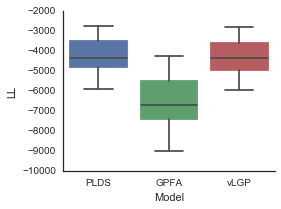

In [104]:
LL = np.zeros((5, 10, 3))
for i in range(5):
    LL[i, :, 0] = np.nansum(stats.poisson.logpmf(PLDSCV_vLGP[i]['y'], PLDSCV_PLDS[i]['yhat']), axis=(1, 2))
    LL[i, :, 2] = np.nansum(stats.poisson.logpmf(PLDSCV_vLGP[i]['y'], PLDSCV_vLGP[i]['yhat']), axis=(1, 2))
    LL[i, :, 1] = np.nansum(stats.poisson.logpmf(PLDSCV_vLGP[i]['y'], PLDSCV_GPFA[i]['yhat']**2), axis=(1, 2))
plt.figure(figsize=(4, 3));
ax = sns.boxplot(data=pd.DataFrame(LL.reshape((-1, 3)), columns=['PLDS', 'GPFA', 'vLGP']), showfliers=False);
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel('Model');
plt.ylabel('LL')
plt.tight_layout()
# plt.title('Prediction Log-Likelihood');
plt.savefig(os.path.join(figurepath, 'prediction_ll_plds.pdf'))